# inputs

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcsly3420'
### ffb ###
# smalldata_folder='/cds/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### call ffb from psana ###
# smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### psana ###
smalldata_folder='/reg/d/psdm/xcs/'+exper+'/hdf5/smalldata/'


# outpath='/reg/d/psdm/xcs/'+exper+'/results/UserCode/slraj/ReducedData/'
outpath='/cds/home/s/slraj/code/ScatteringCode/'


Import Complete!


# no scan var

In [5]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        # 'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        # 'ttFLTPOS_PS'   : 'tt/FLTPOS_PS', ## in picoseconds
        # 'ttREFAMPL'     : 'tt/REFAMPL',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 
        # 'lxt_ttc'       : 'epics/lxt_ttc',
        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    
        ## scattering detector error
        #'azav_sqr'     :  'epix10k2M/azav_azav_square',
        # 'pix_per_azav'  :  'UserDataCfg/epix10k2M/azav__azav_norm',
    
        # ## spectroscopy variables
        # 'epix_roi0'        : 'epix_1/ROI_0_area',
        # 'epix_roi0_sum'    : 'epix_1/ROI_0_sum',
        # 'droplet_x'        : 'epix_1/ragged_droplet_photon_j', #nondispersive axis
        # 'droplet_y'        :  'epix_1/ragged_droplet_photon_i', #energy dispersive
        # 'epix_roi0_limits' : 'UserDataCfg/epix_1/ROI_0__ROI_0_ROI',

        }

In [6]:
# setbins=np.arange(0.e-12,1e-12,.01e-12)
setbins=np.arange(-1e-12,5e-12,.05e-12)
print(setbins.shape)

paramDict2= {
        # 'binSetup'  : 'unique',
        'binSetup'  : 'points',
        'binSet2'   : 300,
        # 'binSetup'  : 'fixed',
        # 'binSet2'   : setbins,
        'binMethod' : 'ave', 
        'qnorm'     : (3,4), 
        'qrange'    : (.2,4.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, # if nonzero, use azav_std as filter
        'ipm'    : 4, # select ipm to use
        'corr_filter' : False,
        'ipm_filter' : (1,None), # if corr_filter, can set limits for ipm intensity
        'Iscat_threshold'  : 1, #lower limit for 
    
        'use_TT'   :  False,  #options are True, False, and 'filter'  ('filter is for filtering only) 
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : True, # ebeam photon energy correction
        'NonLin_corr': 'SVDbyBin', #None, SVD, poly, or SVDbyBin
        
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,
    
        'showSVD': False, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot':None, #how to slice up plots displayed at end
        'smooth':None, #smoothinng before svd?
        'overwrite': True,
        'save_mat': False,
    
    
        }



(120,)


In [8]:
inDir=smalldata_folder
outDir=outpath

# runs=[216]
runs=np.arange(216,237)


def RedNoScanV(inDir,exper,runs,outDir,paramDict1,varDict):
    for run in runs:
        fname=inDir+exper+'_Run%04i.h5'%run
        paramDict=paramDict1.copy()
        print('loading ', fname)
        outDict={}
        then=time.time()
        LoadH5(fname,outDir,varDict,paramDict, outDict)
        setupFilters(paramDict,outDict)
        IscatFilters(paramDict,outDict)
        # eBeamFilter(paramDict,outDict)
        if paramDict['use_TT']==True or paramDict['use_TT']=='filter':
            TTfilter(paramDict,outDict)
        now = time.time() #Time after it finished
        print(now-then, " seconds")
        saveReduction(outDir,paramDict,outDict)

        outDict['xs']=np.arange(outDict['h5Dict']['azav'].shape[0])
        # MakeScanAx(paramDict,outDict,tt_corrNew=None)
        DarkSubtract(paramDict,outDict)
        NormalFactor(paramDict,outDict)
        if paramDict['energy_corr']:
            EnergyCorr(paramDict,outDict)
        if paramDict['NonLin_corr'] is not None:
            DetectorNonlinCorr(paramDict,outDict)
        doDifference(paramDict,outDict)
        now = time.time() #Time after it finished
        print(now-then, " seconds")

        AveAllShots(paramDict, outDict)
        now = time.time() #Time after it finished
        print(now-then, " seconds")

        if paramDict['aniso']:
            doAnisotropy(paramDict,outDict)
        saveDictionary(outDir+'npy/',paramDict,outDict)
        overviewPlot(outDir+'figures/',paramDict,outDict)
        now = time.time() #Time after it finished
        print(now-then, " seconds")

loading  /reg/d/psdm/xcs/xcsly3420/hdf5/smalldata/xcsly3420_Run0216.h5
basename is  xcsly3420_Run0216
scan variable is  newdelay
finished loading h5
calculated Iscat
setupFilters - done!
23.692615747451782  seconds
saved reduction.png


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:106: RuntimeWarning: Mean of empty slice
  darkMean = np.nanmean(dark,0)


x-ray off subtraction done!
normalize data
(846,) (30002, 11, 846)


/cds/home/s/slraj/code/ScatteringCode/LCLSDataToolsNew/DiffBinFns.py:149: RuntimeWarning: Mean of empty slice
  cake=np.nanmean(divAny(cspad_azav[early_x,:,:],normal_factor[early_x,:]),0) #normalize by norm


normalize data done!
normalization applied
applying energy correction
do SVD nonlinear corrections for each phi bin
nonlinear correction - done!
starting difference signal
Difference Signal Done!
64.52506279945374  seconds
Averaging all shots difference signals
Average done!
69.3880660533905  seconds
saved output to /cds/home/s/slraj/code/ScatteringCode/npy/xcsly3420_Run0216_out.npy
17035/30002 events used
plotting azavs
logscan False
(1, 846)
(846,)
done
70.13829445838928  seconds
loading  /reg/d/psdm/xcs/xcsly3420/hdf5/smalldata/xcsly3420_Run0217.h5
basename is  xcsly3420_Run0217
scan variable is  newdelay
finished loading h5
calculated Iscat
setupFilters - done!
23.457788228988647  seconds
saved reduction.png
x-ray off subtraction done!
normalize data
(846,) (30003, 11, 846)
normalize data done!
normalization applied
applying energy correction
do SVD nonlinear corrections for each phi bin
nonlinear correction - done!
starting difference signal
Difference Signal Done!
66.025553703308

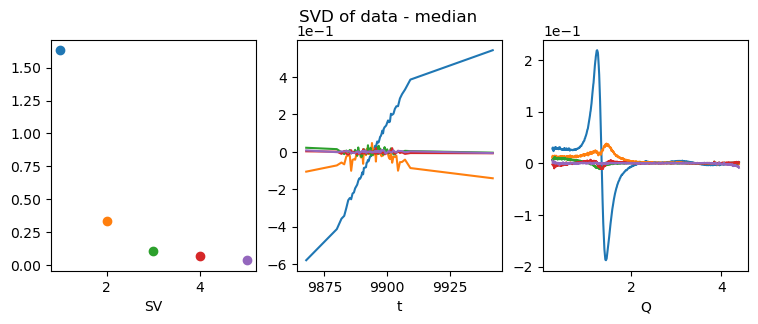

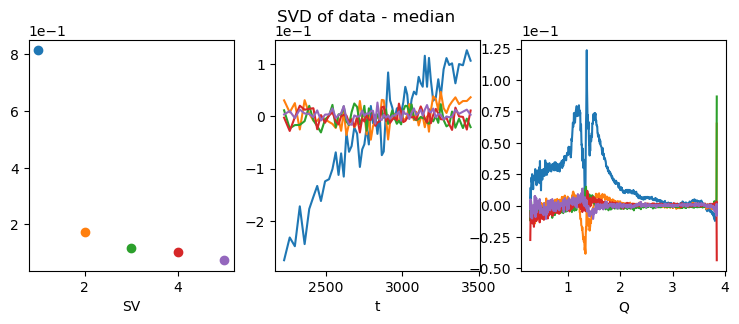

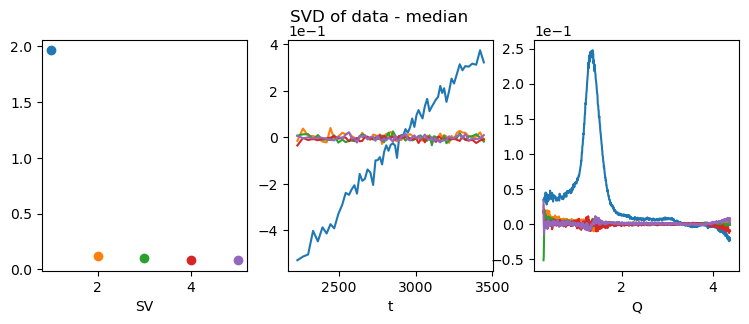

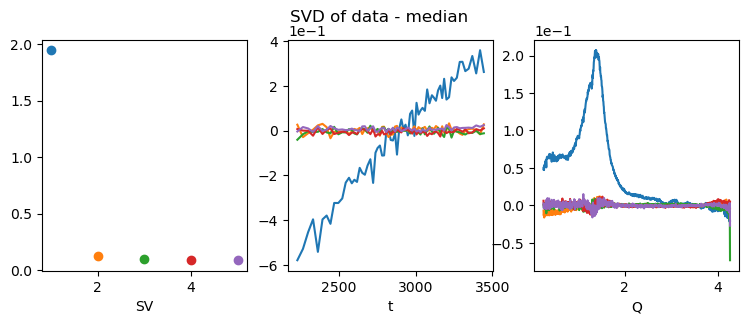

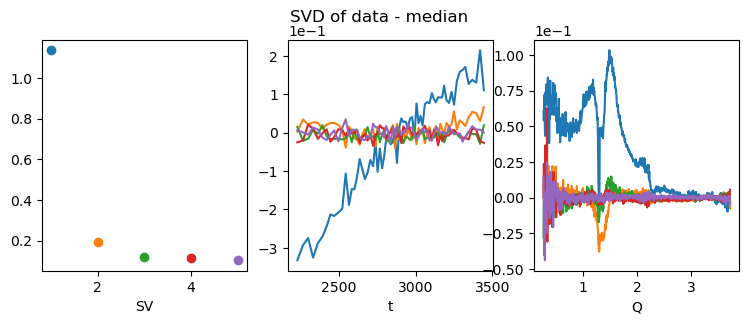

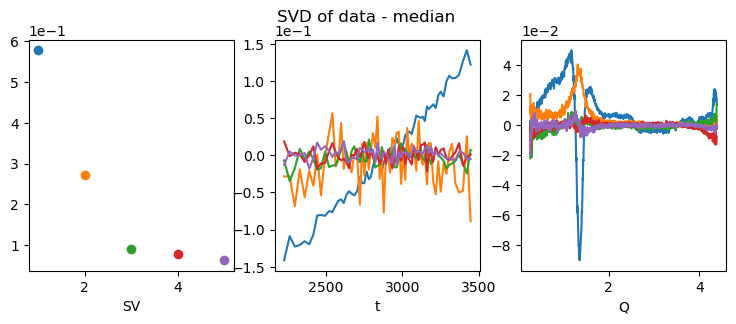

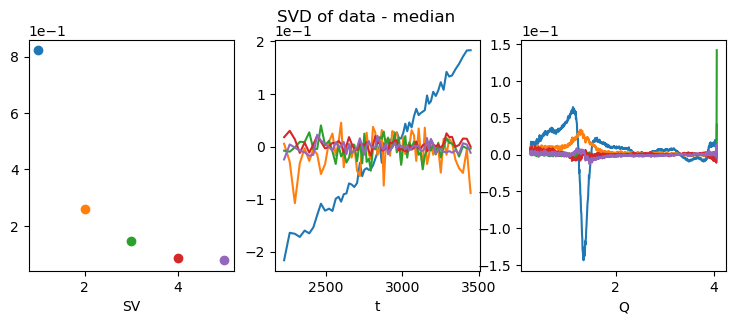

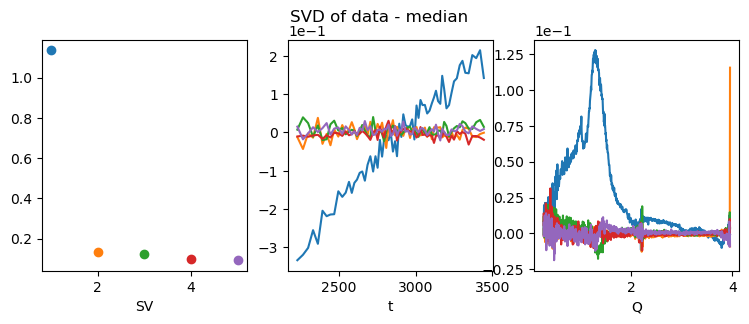

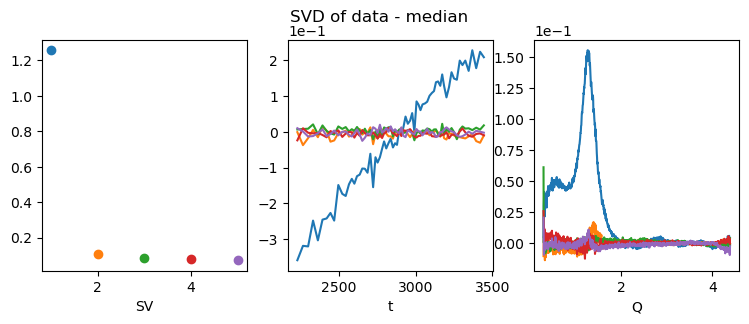

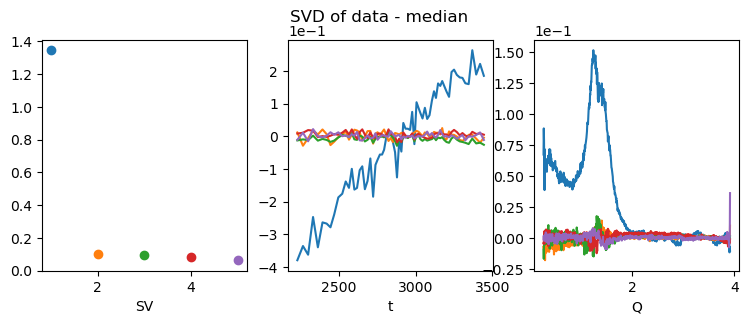

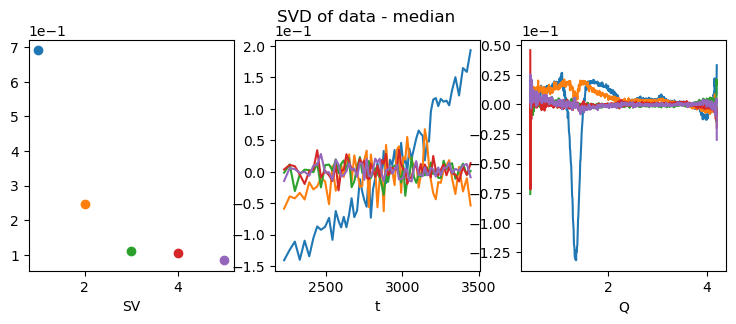

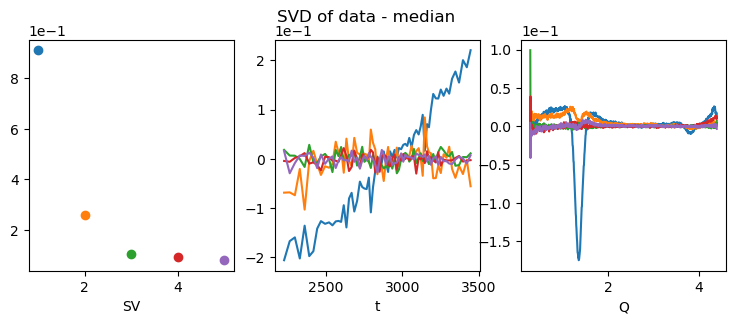

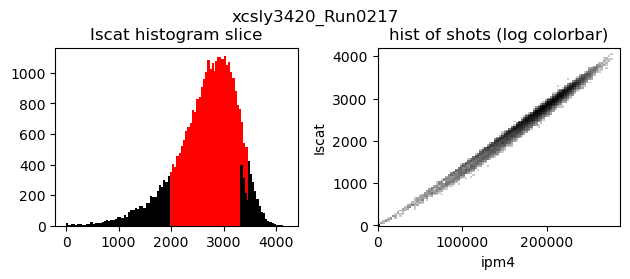

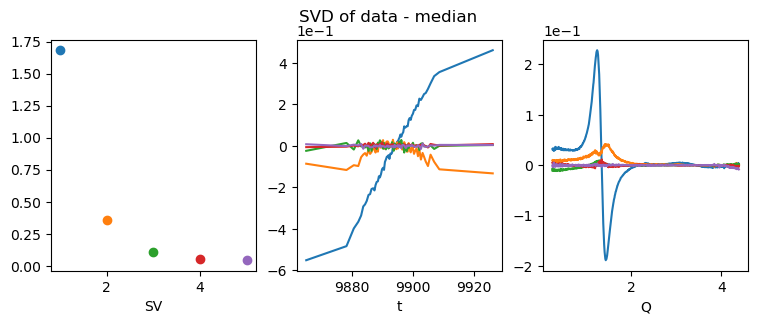

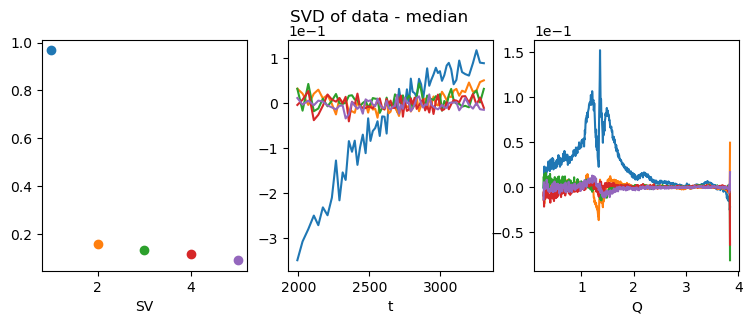

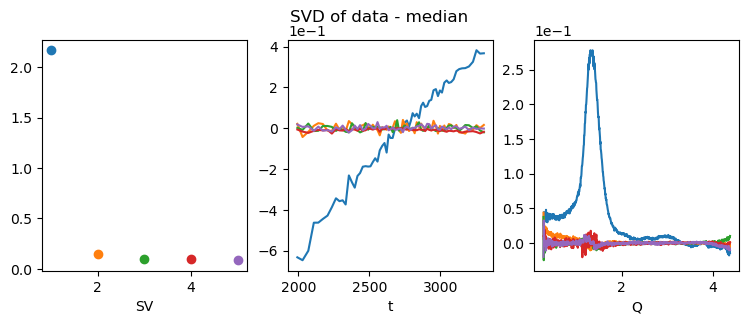

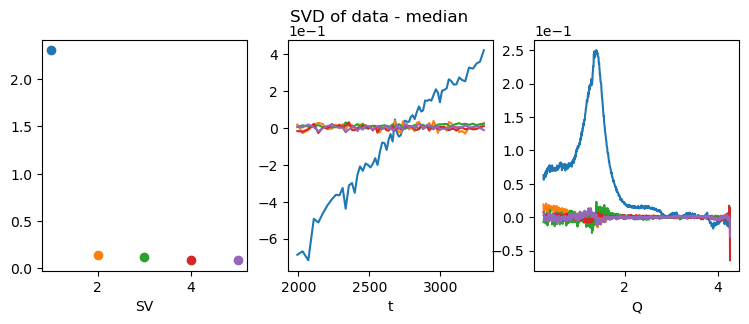

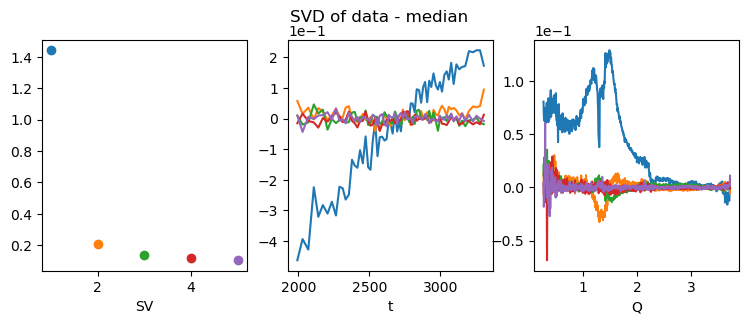

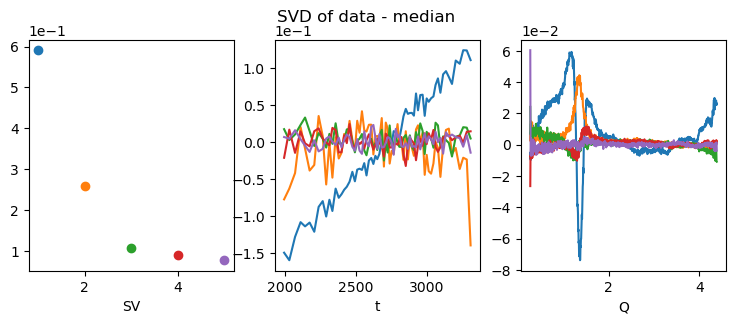

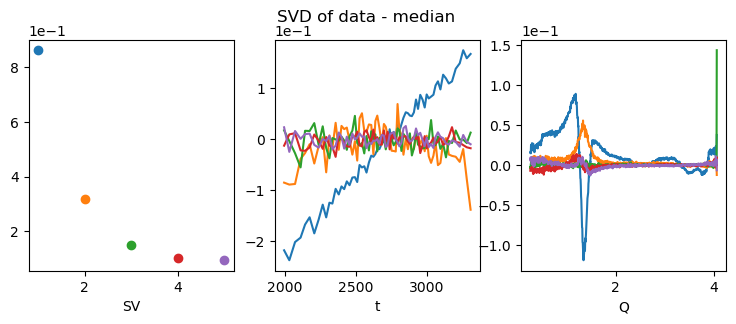

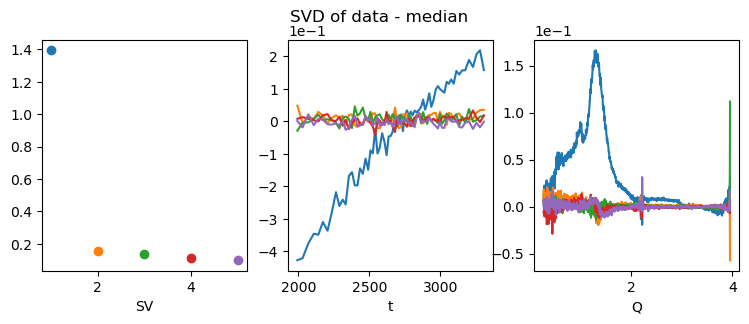

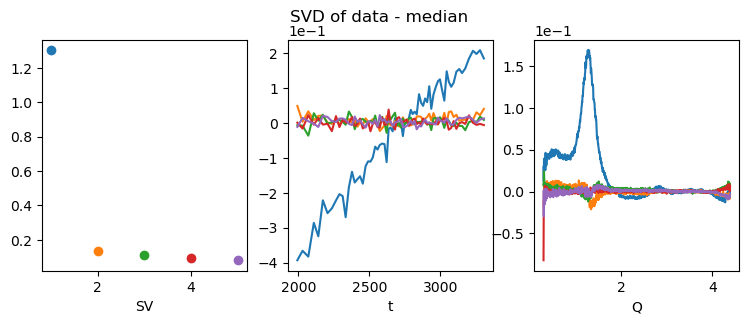

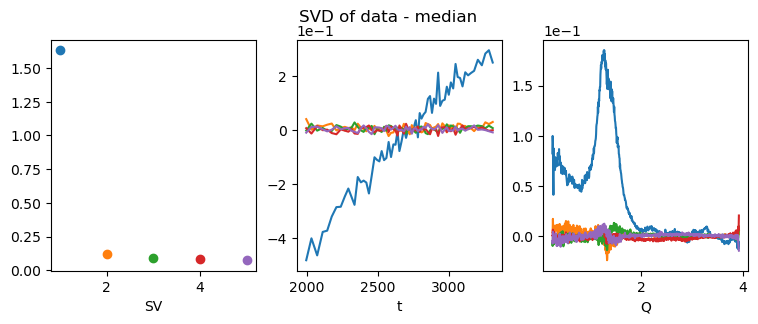

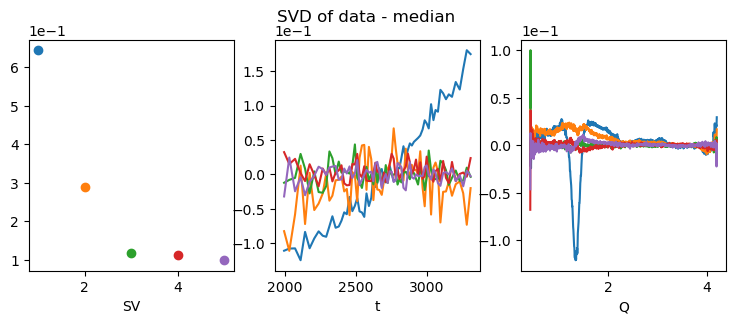

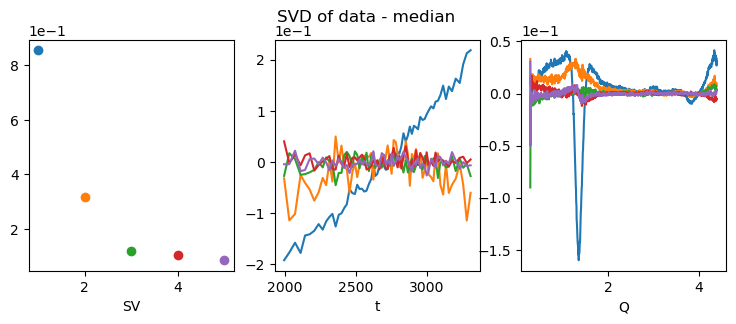

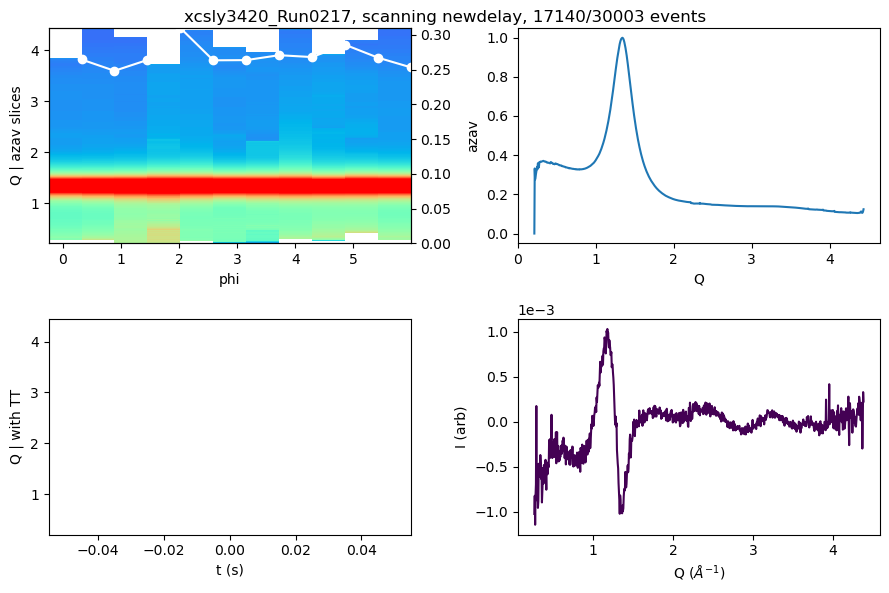

In [10]:
runs=[216,217]
RedNoScanV(smalldata_folder,exper,runs,outpath,paramDict2,varDict)

# load and plot

In [15]:
fpath='/reg/d/psdm/xcs/xcsx51920/results/ReducedData/npy/'
nnames=['523']
allout={}
S0=[]
S2=[]
for nn in nnames:
    allout[nn]=np.load(fpath+exper+'_Run%04i_out.npy'%int(nn),allow_pickle=True).item()
    S0.append(allout[nn]['S0'])
    S2.append(allout[nn]['S2'])    
S0=np.array(S0).squeeze()
S2=np.array(S2).squeeze()
Power=np.array([33.25,20.65,9.80,3.85])
qs=allout[nn]['qs']

outDict={'allout':allout, 'runs':nnames,'qs':qs,'power':Power,'S0':S0,'S2':S2}
np.save('/reg/d/psdm/xcs/xcsx51920/results/ReducedData/stack_npy/combo_332_to_225_pwr.npy',outDict)

TypeError: Dimensions of C (883, 34) are incompatible with X (4) and/or Y (883); see help(pcolormesh)

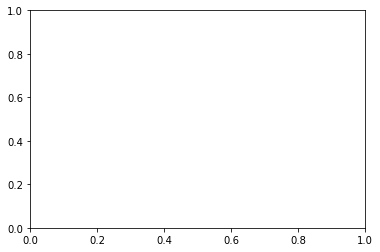

In [8]:
plot_2d(Power,qs,S0)
plt.suptitle('S0')
plt.xlabel('laser power (uJ)')
plot_2d(Power,qs,S2)
plt.suptitle('S2')
plt.xlabel('laser power (uJ)')

# stack

In [57]:
## make stack
runpath=outpath+'npy/'

runs2=np.arange(216,237)

stackDict=StackNoScanVar(runpath,exper,runs2,method='bincount')

In [58]:
stackDict.keys()

dict_keys(['aveData', 'sumBC', 'ts', 'qs', 'phis', 'runs', 'method'])

In [59]:
## save stack
outname=exper+'Stack_216-236'

np.save(outpath+outname+'.npy',stackDict)

In [60]:
## get variables from stack dictionary

print(stackDict.keys())
diff=stackDict['aveData']
ts=stackDict['ts']
qs=stackDict['qs']
phis=stackDict['phis']

# S0, err_S0, S2, err_S2=S0S2(diff,phis,fil=None,shift_n=1,deg=None)
# outdict=SnFitT(2,diff,qs,phis[:-1],1.3051,shift_n=1)

dict_keys(['aveData', 'sumBC', 'ts', 'qs', 'phis', 'runs', 'method'])


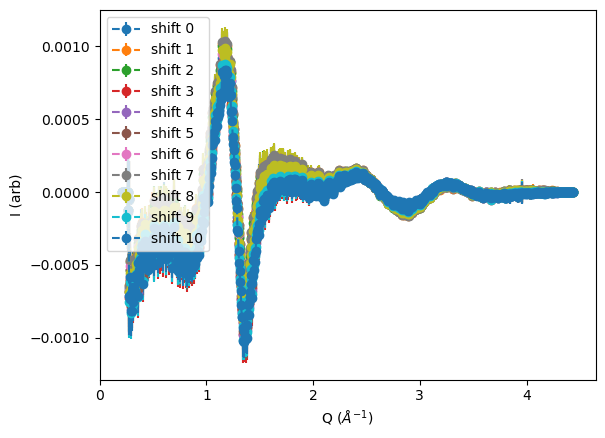

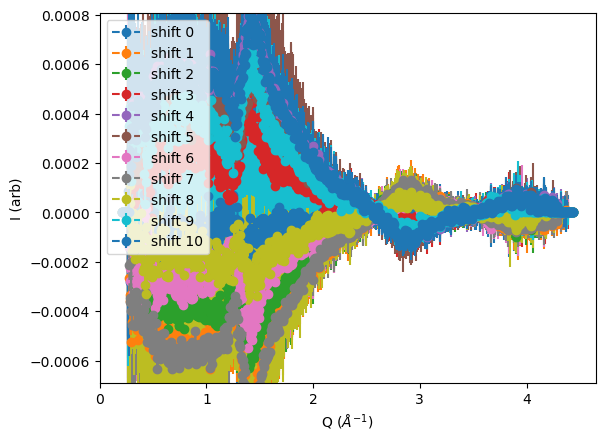

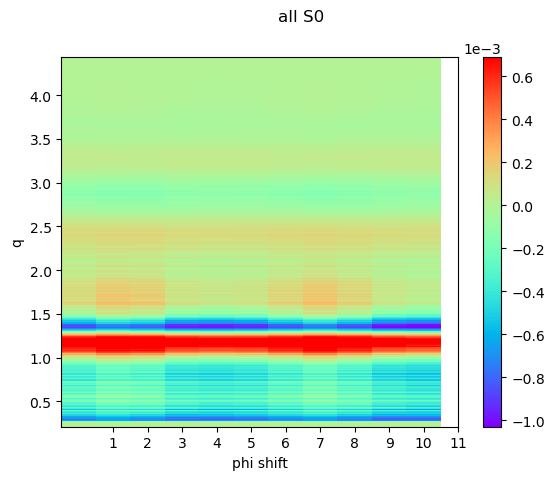

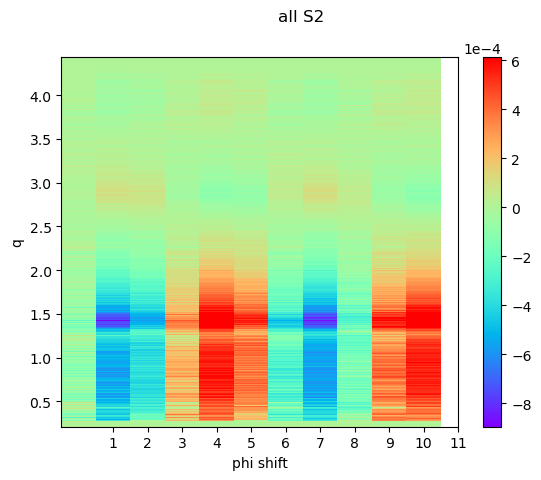

In [63]:
aa=S0S2_check(diff[None,:,:],qs,phis)

In [68]:
S0, err_S0, S2, err_S2=S0S2(diff[None,:,:],phis,fil=None,shift_n=0,deg=None)

shift is 2 degrees
1
0shift is 34 degrees
1
0

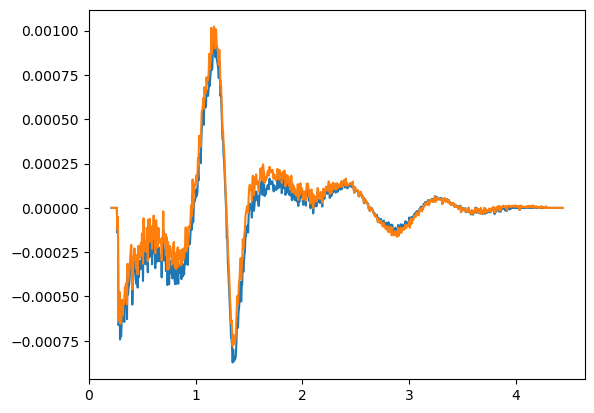

In [69]:
plt.plot(qs,S0.squeeze())

# Stack Fn

In [56]:
def StackNoScanVar(inpath,exper,runs,base=None, method='bincount'):
    ''' for runs in experiment, load .npy files from inpath and stack runs using method specified.
    Methods that return average signal per t bin:
    'bincount' = weigh each run by number of shots per bin and sum, then divide by total shots in bin
    'WAve' = weighted average for each bin using bin_err
    Methods that return total signal per t bin:
    'Sum' = just sum values for each t bin
    
    base=None or base='_01' for inpath+exper+'_Run%04i_01_out.npy' etc 
    '''
    
    ## load data
    AllData=[]
    AllTs=[]
    AllQs=[]
    AllPhis=[]
    AllBC=[]
    AllErr=[]
    for run in runs:
        if base is None:
            data1=np.load(inpath+exper+'_Run%04i_out.npy'%run,allow_pickle=True).item()
        else:
            data1=np.load(inpath+exper+'_Run%04i'%run+base+'_out.npy',allow_pickle=True).item()
        AllData.append(data1['diff_bin'])
        AllTs.append(data1['xcenter'])
        AllQs.append(data1['qs'])
        AllPhis.append(data1['phis'])
        AllBC.append(data1['xbin_occupancy'])
        if method=='WAve':
            AllErr.append(data1['diff_err'])
        
        
    ## check that all ts and qs are the same or throw error 
    AllTs=np.array(AllTs,dtype=float)
    ts=np.array([0])

    try:
        AllQs=np.array(AllQs,dtype=float)
        qs=np.unique(AllQs,axis=0).squeeze()
        assert len(qs.shape)==1
    except:
        print('more than one unique q axis')
        
    try:
        AllPhis=np.array(AllPhis,dtype=float)
        phis=np.unique(AllPhis,axis=0).squeeze()
        assert len(phis.shape)==1
    except:
        print('more than one unique phi axis')

    AllData=np.array(AllData).squeeze() # runs x phis x qs array
    AllBC=np.array(AllBC) #runs 
    ##  weigh each run by number of shots per bin and sum, then divide by total shots in bin
    if method=='bincount':
        AllD2=divAny(AllData,1/AllBC,axis=(1,2,0)) ## multiply sig/shot and BC (shots/bin)
        sumD=np.nansum(AllD2,axis=0) ##total signal for each bin
        sumBC=np.nansum(AllBC,axis=0) ##total shots per bin
        aveD=divAny(sumD,sumBC,axis=(1,0)) #average signal per shot per bin
        stackDict={'aveData':aveD,'sumBC':sumBC,'ts':ts,'qs':qs,'phis':phis,'runs':runs,'method':method}
        return stackDict
